In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
from utils import load_data

FOLDER_PATH = "sentiment_datasets/projekt2_data"

data_df = load_data(FOLDER_PATH, df_delimiter=",")
data_df.head(10)

,SentenceId,Phrase,Sentiment,df_
0,8068,feminist conspiracy theorist,2,2
1,8068,conspiracy theorist,2,2
2,8068,theorist,2,2
3,8068,named dirty dick,2,2
4,8068,dirty dick,2,2
5,8069,"the aaa of action, xxx is a blast of adrenalin...",4,2
6,8069,the aaa of action,3,2
7,8069,the aaa,2,2
8,8069,aaa,2,2
9,8069,", xxx is a blast of adrenalin, rated eee for e...",4,2


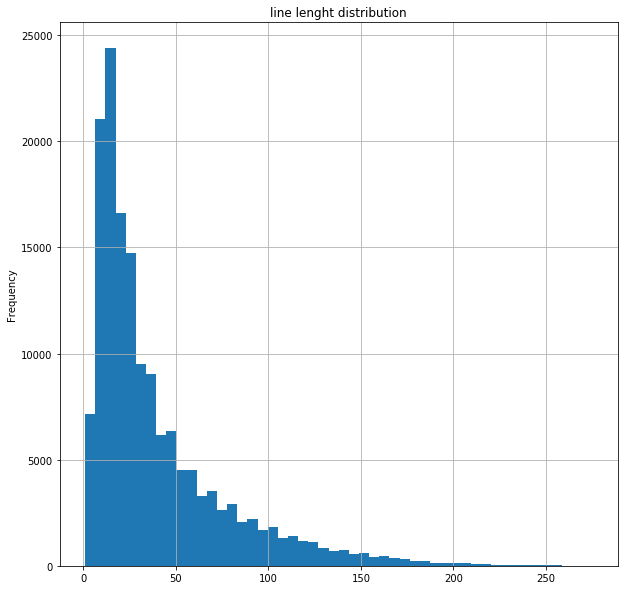

In [4]:
data_df["Phrase"].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

# Character Level RNN

In [5]:
from preprocess_data import preprocess_data_char
from models import model_rnn
from layers import OneHotLayer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from utils import get_proper_callback
from utils_result import save_report

W0521 23:14:57.952896 139693678757696 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [6]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), int2char = preprocess_data_char(data_df, x_label="Phrase", y_label="Sentiment", max_len_seq=200)

In [7]:
callback_params = {
    "histogram_freq": 1,
    "write_graph": True,
    "write_images": True
}

fit_params = {
    "x": x_train,
    "y": y_train,
    "batch_size": 64,
    "epochs": 50,
    "validation_data": (x_val, y_val) 
}

In [8]:
VOCAB_SIZE = len(int2char)
MAX_LEN_SEQ = x_train.shape[1]
EMB_OUTPUT_DIM = min(32, VOCAB_SIZE)

## One-Hot Layer

In [9]:
model_params_ohl = {
    "shape": x_train.shape[1:],
    "input_dtype": x_train.dtype,
    "emb_layer": OneHotLayer(input_dim=VOCAB_SIZE),
    "out_units": np.unique(y_train).shape[0],
    "out_activation": "softmax",
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "is_bert": False
}

model_ohl = model_rnn(model_params_ohl)

Instructions for updating:
Colocations handled automatically by placer.


W0521 23:15:02.651003 139693678757696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0521 23:15:02.659601 139693678757696 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
callback_params["log_dir"] = "logs/fit/char_level/ohl/"+ datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
fit_params["callbacks"] = [get_proper_callback(TensorBoard, callback_params)]
fit_params["callbacks"] += [EarlyStopping(patience=5)]

history_ohl = model_ohl.fit(**fit_params)
save_report(model_ohl, "model_ohl", history_ohl.history)

Train on 139999 samples, validate on 7800 samples
Instructions for updating:
Use tf.cast instead.


W0521 23:15:07.668621 139693678757696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0521 23:15:07.760468 139693678757696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Epoch 1/50
139999/139999 [==============================] - 537s 4ms/sample - loss: 1.2522 - acc: 0.5030 - val_loss: 1.2216 - val_acc: 0.4917
Epoch 2/50
139999/139999 [==============================] - 533s 4ms/sample - loss: 1.2045 - acc: 0.5188 - val_loss: 1.2235 - val_acc: 0.4956
Epoch 3/50
139999/139999 [==============================] - 528s 4ms/sample - loss: 1.1940 - acc: 0.5200 - val_loss: 1.2132 - val_acc: 0.4997
Epoch 4/50
139999/139999 [==============================] - 517s 4ms/sample - loss: 1.1851 - acc: 0.5228 - val_loss: 1.2182 - val_acc: 0.4981
Epoch 5/50
110912/139999 [======================>.......] - ETA: 1:46 - loss: 1.1756 - acc: 0.5272

## Embedding Layer

In [ ]:
model_params_el = {
    "shape": x_train.shape[1:],
    "input_dtype": x_train.dtype,
    "emb_layer": Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_OUTPUT_DIM, input_length=MAX_LEN_SEQ, trainable=True),
    "out_units": np.unique(y_train).shape[0],
    "out_activation": "softmax",
    "loss": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "is_bert": False
}

model_el = model_rnn(model_params_el)

In [ ]:
callback_params["log_dir"] = "logs/fit/char_level/el/"+ datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
fit_params["callbacks"] = [get_proper_callback(TensorBoard, callback_params)]
fit_params["callbacks"] += [EarlyStopping(patience=5)]

history_el = model_el.fit(**fit_params)
save_report(model_el, "model_el", history_el.history)